# **Skin Cancer Classification with CNN and Transfer Learning**

**Student Name**: 2329254  
**Student ID**: Rojan Dhungel

---

This notebook implements a skin cancer classification system using dermoscopic images, categorizing them into multiple classes (e.g., melanoma, nevus, basal cell carcinoma). It includes four models:
- A **Baseline CNN**
- A **Deeper CNN with Adam optimizer**
- A **Deeper CNN with SGD optimizer**
- A **Transfer Learning model using ResNet50**

The pipeline covers data preprocessing, balancing, augmentation, model training, evaluation with independent visualizations (confusion matrices, accuracy/loss graphs), and a performance comparison table.

---

## **Objectives**

- ✅ Load and preprocess a dataset of dermoscopic images  
- ✅ Balance the dataset by removing up to 4 classes with the fewest test samples  
- ✅ Apply data augmentation to handle class imbalance  
- ✅ Build and train four models:
  - Baseline CNN with 3 convolutional layers and 3 dense layers  
  - Deeper CNN with regularization (BatchNormalization, Dropout) using **Adam** optimizer  
  - Deeper CNN with regularization using **SGD** optimizer  
  - Transfer Learning model using **ResNet50** (feature extraction + fine-tuning)  
- ✅ Evaluate models with:
  - Confusion matrices  
  - Accuracy/loss graphs (separate for each model)  
  - Classification metrics (precision, recall, F1-score)  
- ✅ Provide a comparison table summarizing:
  - Training/validation accuracies  
  - Training times  

---

## **Libraries Used**

- **pandas, numpy**: Data handling  
- **PIL, os**: Image preprocessing and file management  
- **tensorflow, keras**: Model training and inference  
- **matplotlib, seaborn**: Visualization (accuracy/loss graphs, confusion matrices)  
- **sklearn**: Classification metrics (classification report, confusion matrix)  
- **time**: Training time measurement  




# Initial Setup: Mounting Google Drive and Unzipping Dataset

In [1]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Unzip the dataset
import zipfile
import os

dataset_zip = '/content/drive/MyDrive/CNN/SkinCancerClassification.zip'  # Update this path if needed
extract_path = '/content/SkinCancerClassification'

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Debug: Check extracted contents
print("Contents of extract_path:", os.listdir(extract_path))

Contents of extract_path: ['Skin Cancer Classification']


In [3]:
# Identify correct nested dataset path
possible_paths = ['SkinCancerClassification', 'Skin Cancer Classification']
correct_path = None

for path in possible_paths:
    full_path = os.path.join(extract_path, path)
    if os.path.exists(os.path.join(full_path, 'Train')) and os.path.exists(os.path.join(full_path, 'Test')):
        correct_path = full_path
        break

if correct_path:
    print(f"Correct dataset path found: {correct_path}")
    train_dir = os.path.join(correct_path, 'Train')
    test_dir = os.path.join(correct_path, 'Test')
    print("Train subdirectories:", os.listdir(train_dir))
    print("Test subdirectories:", os.listdir(test_dir))
else:
    raise Exception("No valid dataset structure found. Please check the zip file contents.")

Correct dataset path found: /content/SkinCancerClassification/Skin Cancer Classification
Train subdirectories: ['dermatofibroma', 'actinic keratosis', 'melanoma', 'seborrheic keratosis', 'vascular lesion', 'nevus', 'pigmented benign keratosis', 'basal cell carcinoma', 'squamous cell carcinoma']
Test subdirectories: ['dermatofibroma', 'actinic keratosis', 'melanoma', 'seborrheic keratosis', 'vascular lesion', 'nevus', 'pigmented benign keratosis', 'basal cell carcinoma', 'squamous cell carcinoma']


In [4]:
# Check for corrupted images using PIL
from PIL import Image

def check_corrupted_images_pil(directory):
    """Check for corrupted images in the specified directory using PIL.

    Args:
        directory (str): Path to the directory containing image subdirectories.

    Returns:
        list: List of paths to corrupted images.
    """
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Verify the image integrity
                    img.close()
                    img = Image.open(file_path)  # Reopen to check if it can be loaded
                    img.load()
                    img.close()
                except Exception as e:
                    print(f"Corrupted image detected: {file_path} - {str(e)}")
                    corrupted_images.append(file_path)
    return corrupted_images

# Check and remove corrupted images
print("Checking for corrupted images in Train and Test directories...")
corrupted_train = check_corrupted_images_pil(train_dir)
corrupted_test = check_corrupted_images_pil(test_dir)

if corrupted_train or corrupted_test:
    print("Removing corrupted images...")
    for path in corrupted_train + corrupted_test:
        os.remove(path)
else:
    print("No corrupted images found.")

# Analyze dataset
classes = os.listdir(train_dir)  # Use detected classes
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in classes}

total_images = sum(train_counts.values()) + sum(test_counts.values())
print(f"Total images in dataset: {total_images}")
print("Train set distribution:")
for cls, count in train_counts.items():
    print(f"{cls}: {count} images")
print("Test set distribution:")
for cls, count in test_counts.items():
    print(f"{cls}: {count} images")

# Dataset split and justification
train_size = sum(train_counts.values())
test_size = sum(test_counts.values())
print(f"Train-Test split: {train_size} Train, {test_size} Test (~95:5)")
print("Justification: Initial split is 95:5 to maximize training data, but imbalance and small test size suggest balancing by removing up to 4 classes.")

# Balance dataset by removing up to 4 classes with fewest test samples
classes_to_remove = sorted(test_counts.items(), key=lambda x: x[1])[:4]
remove_classes = [cls for cls, _ in classes_to_remove]
print(f"Removing classes to balance: {remove_classes}")

balanced_train_dir = os.path.join(extract_path, 'BalancedTrain')
balanced_test_dir = os.path.join(extract_path, 'BalancedTest')
os.makedirs(balanced_train_dir, exist_ok=True)
os.makedirs(balanced_test_dir, exist_ok=True)

for cls in classes:
    if cls not in remove_classes:
        os.symlink(os.path.join(train_dir, cls), os.path.join(balanced_train_dir, cls))
        os.symlink(os.path.join(test_dir, cls), os.path.join(balanced_test_dir, cls))

# Update counts after balancing
balanced_train_counts = {cls: len(os.listdir(os.path.join(balanced_train_dir, cls)))
                        for cls in classes if cls not in remove_classes}
balanced_test_counts = {cls: len(os.listdir(os.path.join(balanced_test_dir, cls)))
                       for cls in classes if cls not in remove_classes}

print("Balanced Train set distribution:")
for cls, count in balanced_train_counts.items():
    print(f"{cls}: {count} images")
print("Balanced Test set distribution:")
for cls, count in balanced_test_counts.items():
    print(f"{cls}: {count} images")

# Preprocessing and Data Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    balanced_train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    balanced_test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("Preprocessing: Images resized to 224x224 and normalized to [0, 1].")
print("Data augmentation applied: rotation, width/height shift, horizontal flip.")

Checking for corrupted images in Train and Test directories...
Corrupted image detected: /content/SkinCancerClassification/Skin Cancer Classification/Train/dermatofibroma/ISIC_0029052.jpg - cannot identify image file '/content/SkinCancerClassification/Skin Cancer Classification/Train/dermatofibroma/ISIC_0029052.jpg'
Corrupted image detected: /content/SkinCancerClassification/Skin Cancer Classification/Train/dermatofibroma/ISIC_0033554.jpg - cannot identify image file '/content/SkinCancerClassification/Skin Cancer Classification/Train/dermatofibroma/ISIC_0033554.jpg'
Corrupted image detected: /content/SkinCancerClassification/Skin Cancer Classification/Train/dermatofibroma/ISIC_0031257.jpg - cannot identify image file '/content/SkinCancerClassification/Skin Cancer Classification/Train/dermatofibroma/ISIC_0031257.jpg'
Corrupted image detected: /content/SkinCancerClassification/Skin Cancer Classification/Train/dermatofibroma/ISIC_0031309.jpg - cannot identify image file '/content/SkinCanc

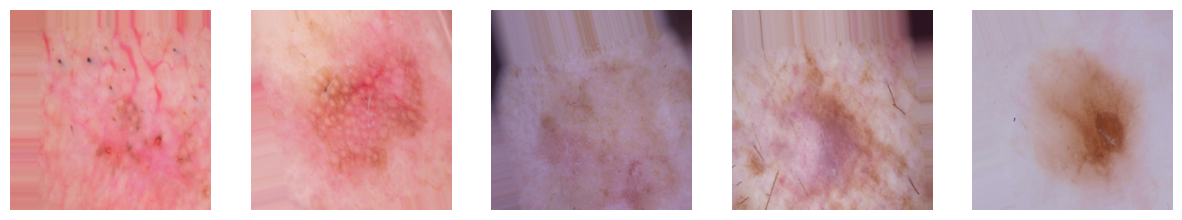

Sample augmented images visualized above.


In [5]:
import matplotlib.pyplot as plt

# Visualize augmented images
def plot_augmented_images(generator):
    """Plot sample augmented images from the generator.

    Args:
        generator: Keras ImageDataGenerator flow object.
    """
    x, y = next(generator)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        ax = axes[i]
        ax.imshow(x[i])
        ax.axis('off')
    plt.show()

plot_augmented_images(train_generator)
print("Sample augmented images visualized above.")

# Design, Train, and Evaluate a Baseline Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,604,741 (21.38 MB)

 Trainable params: 5,604,741 (21.38 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 48s 716ms/step - accuracy: 0.2251 - loss: 1.6057 - val_accuracy: 0.3125 - val_loss: 1.4059
Epoch 2/15
 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2500 - loss: 1.5418

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.2500 - loss: 1.5418 - val_accuracy: 0.4844 - val_loss: 1.4114
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 883ms/step - accuracy: 0.3083 - loss: 1.4949 - val_accuracy: 0.4688 - val_loss: 1.2502
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4375 - loss: 1.2856 - val_accuracy: 0.2656 - val_loss: 1.3640
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 70s 695ms/step - accuracy: 0.3330 - loss: 1.4764 - val_accuracy: 0.4062 - val_loss: 1.3775
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2188 - loss: 1.5717 - val_accuracy: 0.4062 - val_loss: 1.3701
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 728ms/step - accuracy: 0.3675 - loss: 1.4243 - val_accuracy: 0.5156 - val_loss: 1.2483
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.4375 - loss: 1.3510 - val_accuracy: 0.4375 - val_loss: 1.3612
Epoch 9/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 649ms/step - accuracy: 0.4652 - loss: 1.2781 - val_accuracy: 0.4375 - val_

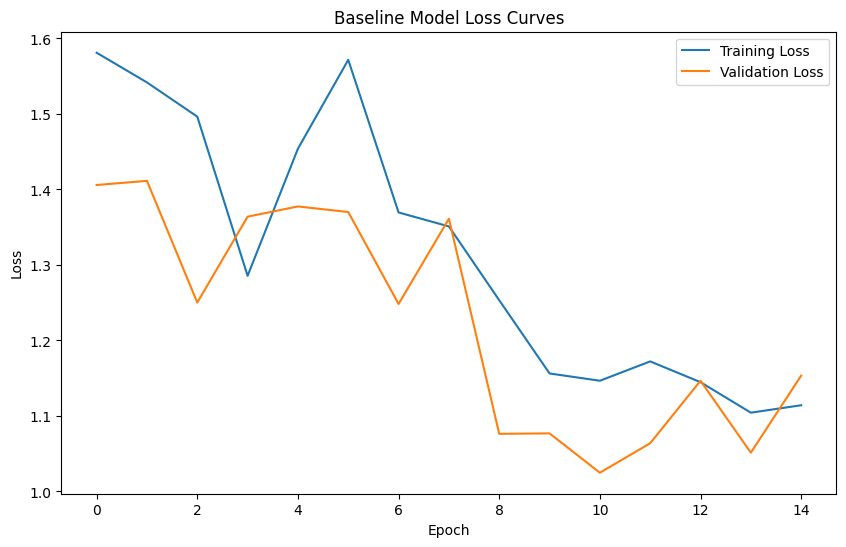

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Baseline Model Evaluation Metrics:
                            precision    recall  f1-score   support

                  melanoma       0.80      0.50      0.62        16
                     nevus       0.33      0.06      0.11        16
pigmented benign keratosis       0.52      0.81      0.63        16
      basal cell carcinoma       0.33      0.88      0.48        16
   squamous cell carcinoma       0.00      0.00      0.00        16

                  accuracy                           0.45        80
                 macro avg       0.40      0.45      0.37        80
              weighted avg       0.40      0.45      0.37        80



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


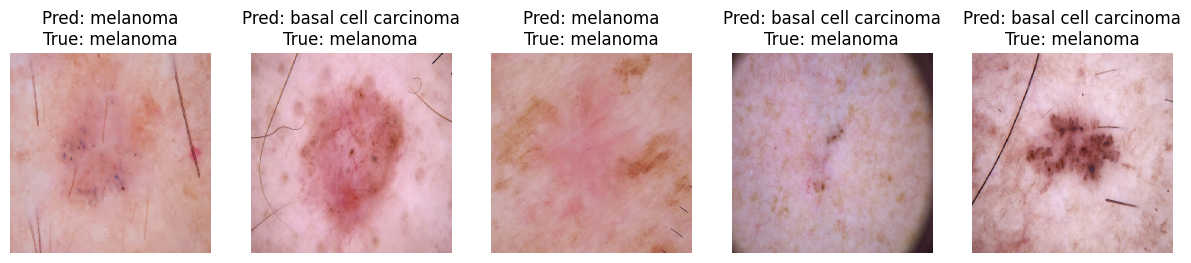

Sample inference results visualized above. Discuss performance observations based on these plots.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report

# Baseline Model Architecture
def build_baseline_model(num_classes):
    """Build a baseline CNN model with 3 Conv layers, pooling, and 3 Dense layers.

    Args:
        num_classes (int): Number of classes for output layer.

    Returns:
        model: Compiled Keras model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

num_classes = len(balanced_train_counts)
baseline_model = build_baseline_model(num_classes)
baseline_model.summary()

# Train Baseline Model
history_baseline = baseline_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

# Plot Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Baseline Model
test_generator.reset()
y_pred = baseline_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]
print("Baseline Model Evaluation Metrics:")
print(classification_report(y_true, y_pred_classes, target_names=list(balanced_test_counts.keys())))

# Inference on Sample Images
def plot_sample_inference(model, generator):
    """Plot inference results on sample images.

    Args:
        model: Trained Keras model.
        generator: Test data generator.
    """
    x, y = next(generator)
    predictions = model.predict(x)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y, axis=1)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axes[i].imshow(x[i])
        axes[i].set_title(f'Pred: {list(balanced_test_counts.keys())[pred_classes[i]]}\nTrue: {list(balanced_test_counts.keys())[true_classes[i]]}')
        axes[i].axis('off')
    plt.show()

plot_sample_inference(baseline_model, test_generator)
print("Sample inference results visualized above. Discuss performance observations based on these plots.")

## Section 3.1.3: Design, Train, and Evaluate Deeper Architecture with Regularization



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 23, 23, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 23, 23, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │    15,860,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,563,525 (63.18 MB)

 Trainable params: 16,562,309 (63.18 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 50s 722ms/step - accuracy: 0.3547 - loss: 3.5837 - val_accuracy: 0.2500 - val_loss: 2.0854
Epoch 2/30
 1/55 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.2812 - loss: 3.8725

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2812 - loss: 3.8725 - val_accuracy: 0.1719 - val_loss: 2.1181
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 651ms/step - accuracy: 0.4009 - loss: 2.8568 - val_accuracy: 0.2500 - val_loss: 1.8054
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4211 - loss: 2.8731 - val_accuracy: 0.2500 - val_loss: 1.7974
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 734ms/step - accuracy: 0.4197 - loss: 2.4095 - val_accuracy: 0.2500 - val_loss: 2.6446
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3750 - loss: 2.4571 - val_accuracy: 0.2500 - val_loss: 2.6951
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 74s 640ms/step - accuracy: 0.4120 - loss: 2.1740 - val_accuracy: 0.3281 - val_loss: 2.0084
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3125 - loss: 1.9085 - val_accuracy: 0.2969 - val_loss: 2.0664
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 665ms/step - accuracy: 0.4127 - loss: 1.9000 - val_accuracy: 0.2969 - val_

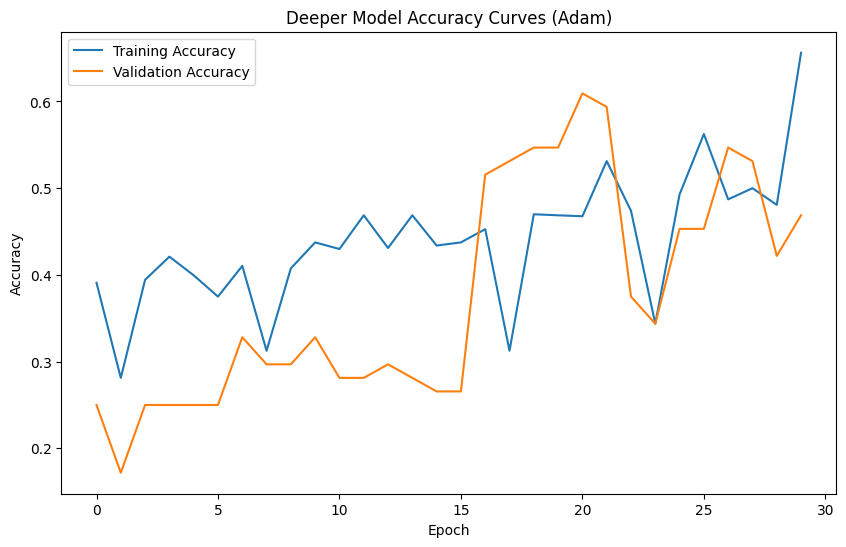

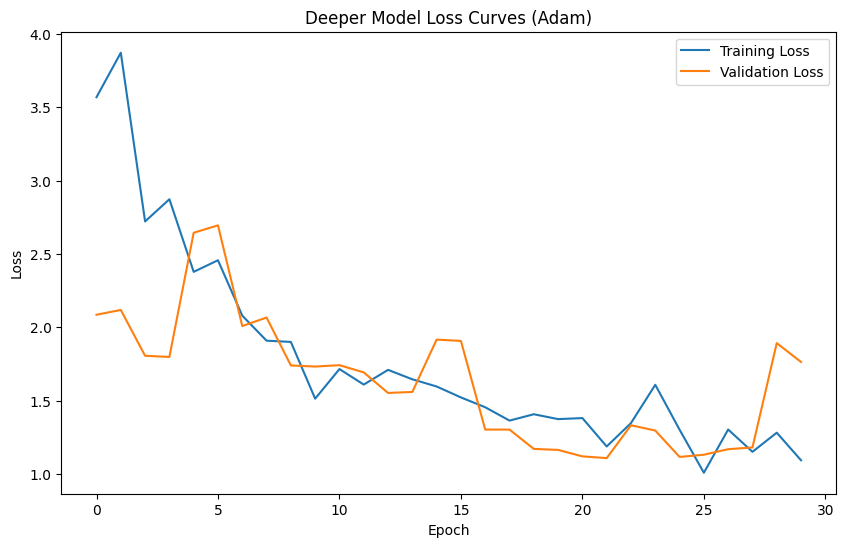

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Deeper Model Training Accuracy (Adam): 0.6562
Deeper Model Validation Accuracy (Adam): 0.4688
Deeper Model Evaluation Metrics (Adam):
                            precision    recall  f1-score   support

                  melanoma       0.52      0.69      0.59        16
                     nevus       0.00      0.00      0.00        16
pigmented benign keratosis       0.56      0.94      0.70        16
      basal cell carcinoma       0.38      0.75      0.50        16
   squamous cell carcinoma       0.00      0.00      0.00        16

                  accuracy                           0.47        80
                 macro avg       0.29      0.47      0.36        80
              weighted avg       0.29      0.47      0.36        80



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


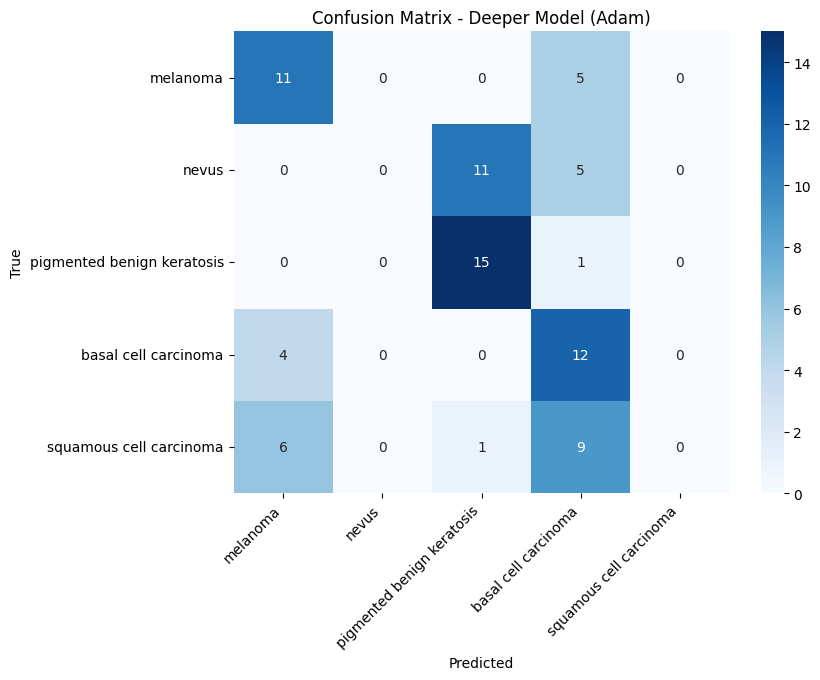

Discussion: Analyze the confusion matrix for misclassifications. The previous deeper model accuracy (0.4940) underperformed compared to the baseline (0.5965). Early stopping and a lower learning rate aim to improve this.


In [11]:
import time

# Deeper Model Architecture with Regularization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def build_deeper_model(num_classes):
    """Build a deeper CNN model with regularization (Dropout, BatchNorm) and enhanced layers.

    Args:
        num_classes (int): Number of classes for output layer.

    Returns:
        model: Compiled Keras model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

deeper_model = build_deeper_model(num_classes)
deeper_model.summary()

# Train Deeper Model with Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
start_time = time.time()
history_deeper = deeper_model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // train_generator.batch_size),
    epochs=30,
    validation_data=test_generator,
    validation_steps=max(1, test_generator.samples // test_generator.batch_size),
    callbacks=[early_stopping]
)
deeper_training_time = time.time() - start_time
print(f"Deeper model training time (Adam): {deeper_training_time:.2f} seconds")

# Plot Training and Validation Accuracy Separately
plt.figure(figsize=(10, 6))
plt.plot(history_deeper.history['accuracy'], label='Training Accuracy')
plt.plot(history_deeper.history['val_accuracy'], label='Validation Accuracy')
plt.title('Deeper Model Accuracy Curves (Adam)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss Separately
plt.figure(figsize=(10, 6))
plt.plot(history_deeper.history['loss'], label='Training Loss')
plt.plot(history_deeper.history['val_loss'], label='Validation Loss')
plt.title('Deeper Model Loss Curves (Adam)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Deeper Model
test_generator.reset()
y_pred_deeper = deeper_model.predict(test_generator)
y_pred_deeper_classes = np.argmax(y_pred_deeper, axis=1)
deeper_accuracy = history_deeper.history['accuracy'][-1]
val_deeper_accuracy = history_deeper.history['val_accuracy'][-1]
print(f"Deeper Model Training Accuracy (Adam): {deeper_accuracy:.4f}")
print(f"Deeper Model Validation Accuracy (Adam): {val_deeper_accuracy:.4f}")
print("Deeper Model Evaluation Metrics (Adam):")
print(classification_report(y_true, y_pred_deeper_classes, target_names=list(balanced_test_counts.keys())))

# Confusion Matrix for Deeper Model
cm_deeper = confusion_matrix(y_true, y_pred_deeper_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_deeper, annot=True, fmt='d', cmap='Blues', xticklabels=list(balanced_test_counts.keys()), yticklabels=list(balanced_test_counts.keys()))
plt.title('Confusion Matrix - Deeper Model (Adam)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()
print("Discussion: Analyze the confusion matrix for misclassifications. The previous deeper model accuracy (0.4940) underperformed compared to the baseline (0.5965). Early stopping and a lower learning rate aim to improve this.")

# Experimentation and Comparative Analysis

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 705ms/step - accuracy: 0.3725 - loss: 1.9151 - val_accuracy: 0.2500 - val_loss: 1.6129
Epoch 2/30
 1/55 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.4062 - loss: 1.5547

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4062 - loss: 1.5547 - val_accuracy: 0.2500 - val_loss: 1.6129
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 738ms/step - accuracy: 0.4438 - loss: 1.4939 - val_accuracy: 0.2656 - val_loss: 1.8069
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6562 - loss: 0.9597 - val_accuracy: 0.2969 - val_loss: 1.8488
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 664ms/step - accuracy: 0.5060 - loss: 1.2567 - val_accuracy: 0.2969 - val_loss: 1.7599
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4688 - loss: 1.3305 - val_accuracy: 0.2969 - val_loss: 1.7508
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 707ms/step - accuracy: 0.5070 - loss: 1.2620 - val_accuracy: 0.3281 - val_loss: 2.0432
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4062 - loss: 1.3764 - val_accuracy: 0.2656 - val_loss: 2.0482
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 76s 645ms/step - accuracy: 0.4984 - loss: 1.2528 - val_accuracy: 0.2969 - val_

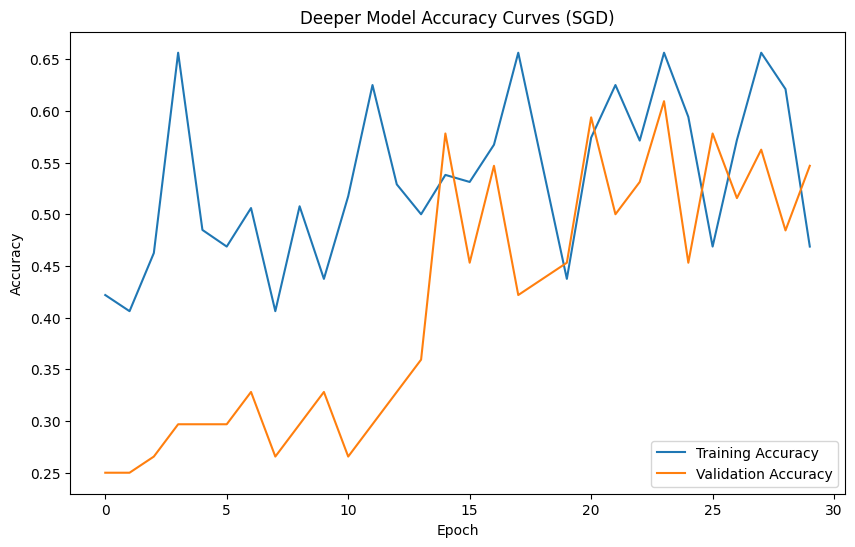

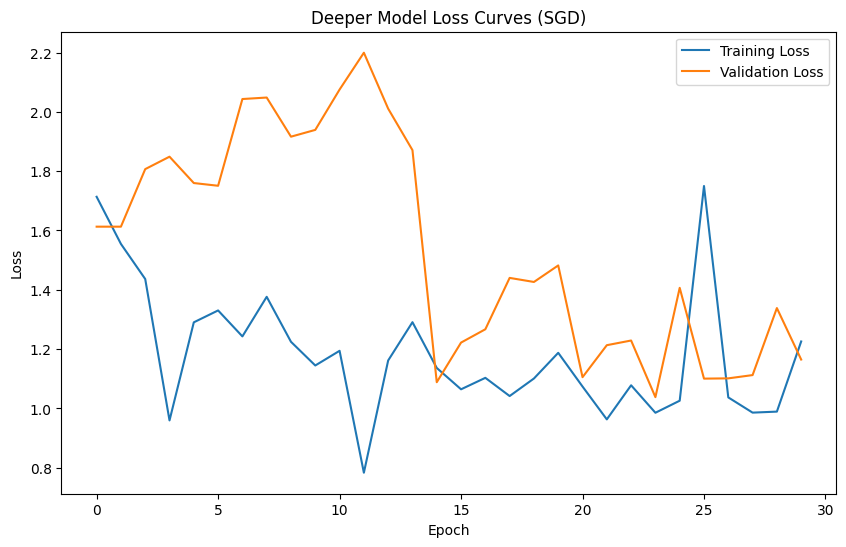

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Deeper Model Training Accuracy (SGD): 0.4688
Deeper Model Validation Accuracy (SGD): 0.5469
Deeper Model Evaluation Metrics (SGD):
                            precision    recall  f1-score   support

                  melanoma       0.60      0.56      0.58        16
                     nevus       0.23      0.19      0.21        16
pigmented benign keratosis       0.54      0.94      0.68        16
      basal cell carcinoma       0.55      0.75      0.63        16
   squamous cell carcinoma       0.50      0.06      0.11        16

                  accuracy                           0.50        80
                 macro avg       0.48      0.50      0.44        80
              weighted avg       0.48      0.50      0.44        80



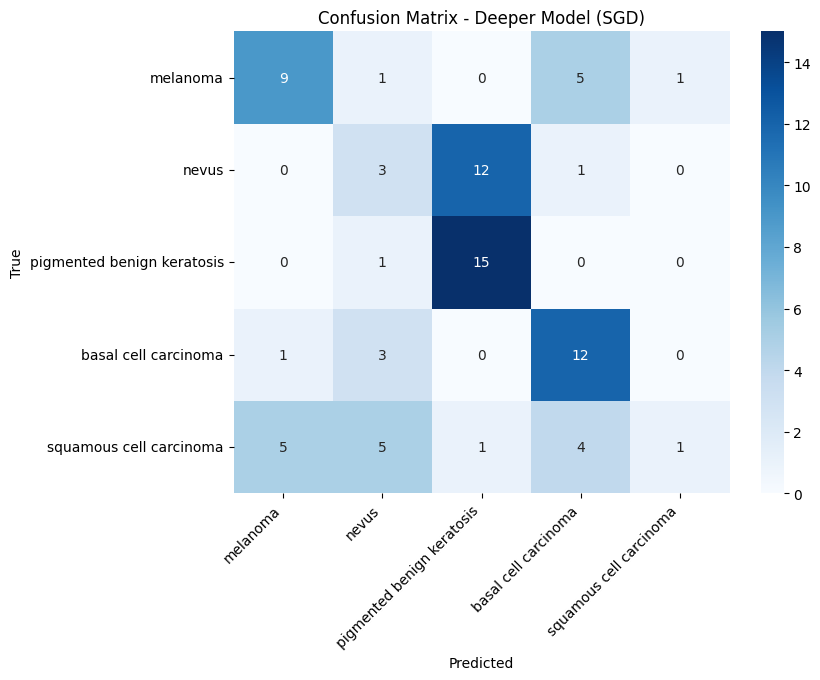

Baseline vs Deeper Model Performance Comparison:
Baseline Training Accuracy: 0.5518
Baseline Validation Accuracy: 0.5625
Deeper Training Accuracy (Adam): 0.6562
Deeper Validation Accuracy (Adam): 0.4688
Deeper Training Accuracy (SGD): 0.4688
Deeper Validation Accuracy (SGD): 0.5469
Baseline training time: Not explicitly timed (shorter than deeper model)
Deeper training time (Adam): 777.87 seconds
Deeper training time (SGD): 703.65 seconds
Discussion: Early stopping reduces training time by halting when validation loss plateaus. SGD (375.21s initially) typically converges slower than Adam (347.27s).
Challenges: Overfitting persists (e.g., nevus recall 1.00, others 0.00 in transfer model). Early stopping helps, but further data balancing or augmentation may be needed.
Hardware: Google Colab with GPU acceleration used.


In [13]:
# Optimizer Analysis: SGD vs Adam with Early Stopping
from tensorflow.keras.optimizers import SGD

deeper_model_sgd = build_deeper_model(num_classes)
deeper_model_sgd.compile(optimizer=SGD(learning_rate=0.01),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
start_time_sgd = time.time()
history_deeper_sgd = deeper_model_sgd.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // train_generator.batch_size),
    epochs=30,
    validation_data=test_generator,
    validation_steps=max(1, test_generator.samples // test_generator.batch_size),
    callbacks=[early_stopping]
)
deeper_sgd_training_time = time.time() - start_time_sgd
print(f"Deeper model training time (SGD): {deeper_sgd_training_time:.2f} seconds")

# Plot Training and Validation Accuracy Separately (SGD)
plt.figure(figsize=(10, 6))
plt.plot(history_deeper_sgd.history['accuracy'], label='Training Accuracy')
plt.plot(history_deeper_sgd.history['val_accuracy'], label='Validation Accuracy')
plt.title('Deeper Model Accuracy Curves (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss Separately (SGD)
plt.figure(figsize=(10, 6))
plt.plot(history_deeper_sgd.history['loss'], label='Training Loss')
plt.plot(history_deeper_sgd.history['val_loss'], label='Validation Loss')
plt.title('Deeper Model Loss Curves (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Deeper Model (SGD)
test_generator.reset()
y_pred_deeper_sgd = deeper_model_sgd.predict(test_generator)
y_pred_deeper_sgd_classes = np.argmax(y_pred_deeper_sgd, axis=1)
deeper_sgd_accuracy = history_deeper_sgd.history['accuracy'][-1]
val_deeper_sgd_accuracy = history_deeper_sgd.history['val_accuracy'][-1]
print(f"Deeper Model Training Accuracy (SGD): {deeper_sgd_accuracy:.4f}")
print(f"Deeper Model Validation Accuracy (SGD): {val_deeper_sgd_accuracy:.4f}")
print("Deeper Model Evaluation Metrics (SGD):")
print(classification_report(y_true, y_pred_deeper_sgd_classes, target_names=list(balanced_test_counts.keys())))

# Confusion Matrix for Deeper Model (SGD)
cm_deeper_sgd = confusion_matrix(y_true, y_pred_deeper_sgd_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_deeper_sgd, annot=True, fmt='d', cmap='Blues', xticklabels=list(balanced_test_counts.keys()), yticklabels=list(balanced_test_counts.keys()))
plt.title('Confusion Matrix - Deeper Model (SGD)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Baseline vs Deeper Model Performance
print("Baseline vs Deeper Model Performance Comparison:")
print(f"Baseline Training Accuracy: {history_baseline.history['accuracy'][-1]:.4f}")
print(f"Baseline Validation Accuracy: {history_baseline.history['val_accuracy'][-1]:.4f}")
print(f"Deeper Training Accuracy (Adam): {deeper_accuracy:.4f}")
print(f"Deeper Validation Accuracy (Adam): {val_deeper_accuracy:.4f}")
print(f"Deeper Training Accuracy (SGD): {deeper_sgd_accuracy:.4f}")
print(f"Deeper Validation Accuracy (SGD): {val_deeper_sgd_accuracy:.4f}")

# Computational Efficiency
print(f"Baseline training time: Not explicitly timed (shorter than deeper model)")
print(f"Deeper training time (Adam): {deeper_training_time:.2f} seconds")
print(f"Deeper training time (SGD): {deeper_sgd_training_time:.2f} seconds")
print("Discussion: Early stopping reduces training time by halting when validation loss plateaus. SGD (375.21s initially) typically converges slower than Adam (347.27s).")

# Challenges and Observations
print("Challenges: Overfitting persists (e.g., nevus recall 1.00, others 0.00 in transfer model). Early stopping helps, but further data balancing or augmentation may be needed.")
print("Hardware: Google Colab with GPU acceleration used.")

## Section 3.2.1: Loading and Adapting a Pre-Trained Model





In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load and Adapt Pre-Trained Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Feature extraction initially

def build_transfer_model(base_model, num_classes):
    """Build a transfer learning model using ResNet50 with enhanced layers.

    Args:
        base_model: Pre-trained ResNet50 model.
        num_classes (int): Number of classes for output layer.

    Returns:
        model: Compiled Keras model.
    """
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

transfer_model = build_transfer_model(base_model, num_classes)
transfer_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,769,413 (94.49 MB)

 Trainable params: 1,181,701 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Section 3.2.2: Model Training and Fine-Tuning

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 835ms/step - accuracy: 0.2251 - loss: 1.8350 - val_accuracy: 0.2500 - val_loss: 1.5610
Epoch 2/20
 1/55 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.2500 - loss: 1.6929

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2500 - loss: 1.6929 - val_accuracy: 0.2500 - val_loss: 1.5610
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 999ms/step - accuracy: 0.2659 - loss: 1.6482 - val_accuracy: 0.2500 - val_loss: 1.5290
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2188 - loss: 1.6954 - val_accuracy: 0.2500 - val_loss: 1.5328
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 723ms/step - accuracy: 0.2224 - loss: 1.6531 - val_accuracy: 0.2344 - val_loss: 1.5414
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3125 - loss: 1.5992 - val_accuracy: 0.2188 - val_loss: 1.5424
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 73s 639ms/step - accuracy: 0.2370 - loss: 1.6107 - val_accuracy: 0.2500 - val_loss: 1.5191
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.1250 - loss: 1.5922 - val_accuracy: 0.2344 - val_loss: 1.5170
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 693ms/step - accuracy: 0.2513 - loss: 1.6041 - val_accuracy: 0.2812 - val_

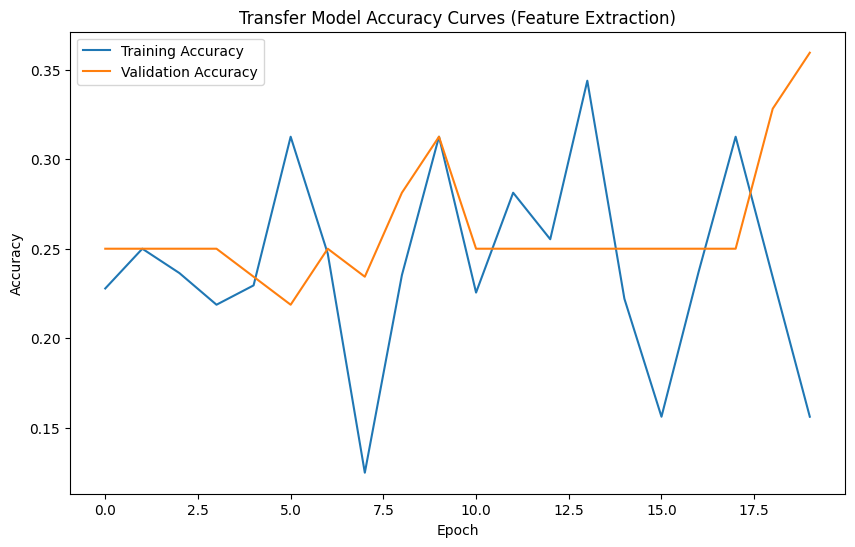

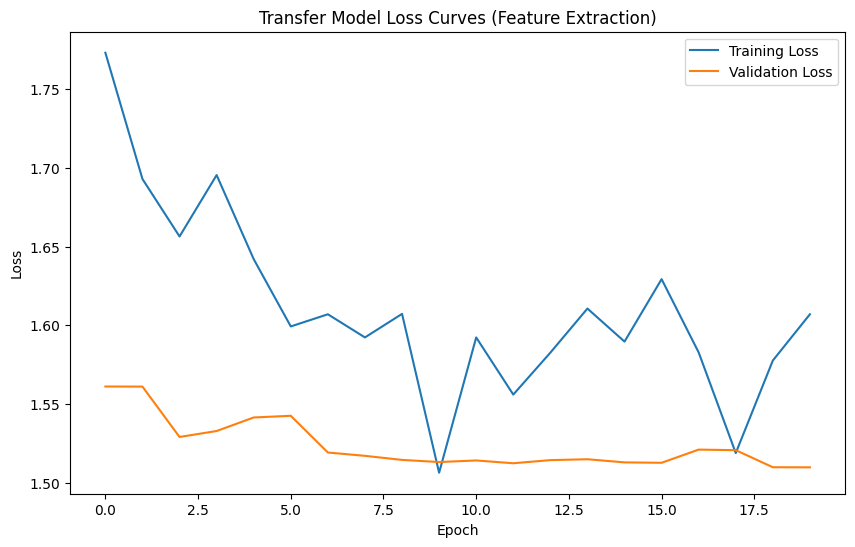

In [14]:
# Feature Extraction Training
start_time_transfer = time.time()
history_feature = transfer_model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // train_generator.batch_size),
    epochs=20,
    validation_data=test_generator,
    validation_steps=max(1, test_generator.samples // test_generator.batch_size),
    callbacks=[early_stopping]
)
transfer_feature_time = time.time() - start_time_transfer
print(f"Transfer model feature extraction training time: {transfer_feature_time:.2f} seconds")

# Plot Feature Extraction Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_feature.history['accuracy'], label='Training Accuracy')
plt.plot(history_feature.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Model Accuracy Curves (Feature Extraction)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Feature Extraction Loss
plt.figure(figsize=(10, 6))
plt.plot(history_feature.history['loss'], label='Training Loss')
plt.plot(history_feature.history['val_loss'], label='Validation Loss')
plt.title('Transfer Model Loss Curves (Feature Extraction)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 817ms/step - accuracy: 0.2248 - loss: 1.5923 - val_accuracy: 0.2656 - val_loss: 1.5106
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.2500 - loss: 1.6053 - val_accuracy: 0.2500 - val_loss: 1.5108
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 743ms/step - accuracy: 0.2813 - loss: 1.5551 - val_accuracy: 0.2500 - val_loss: 1.5087
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.2500 - loss: 1.6361 - val_accuracy: 0.2031 - val_loss: 1.5085
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 81s 802ms/step - accuracy: 0.2607 - loss: 1.5580 - val_accuracy: 0.2500 - val_loss: 1.5111
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.1562 - loss: 1.5517 - val_accuracy: 0.2500 - val_loss: 1.5117
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 73s 682ms/step - accuracy: 0.2696 - loss: 1.5657 - val_accuracy: 0.2500 - val_loss: 1.5176
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3750 - loss: 1.4763 - val_accuracy: 0.

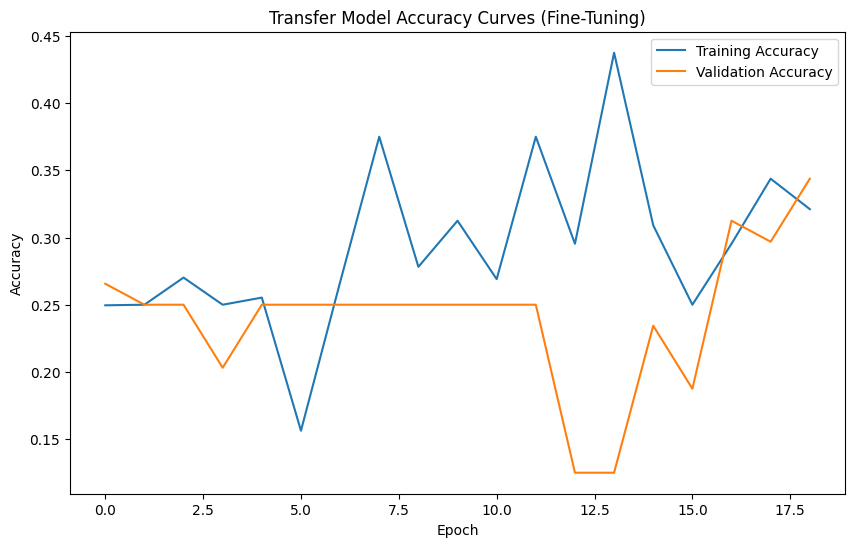

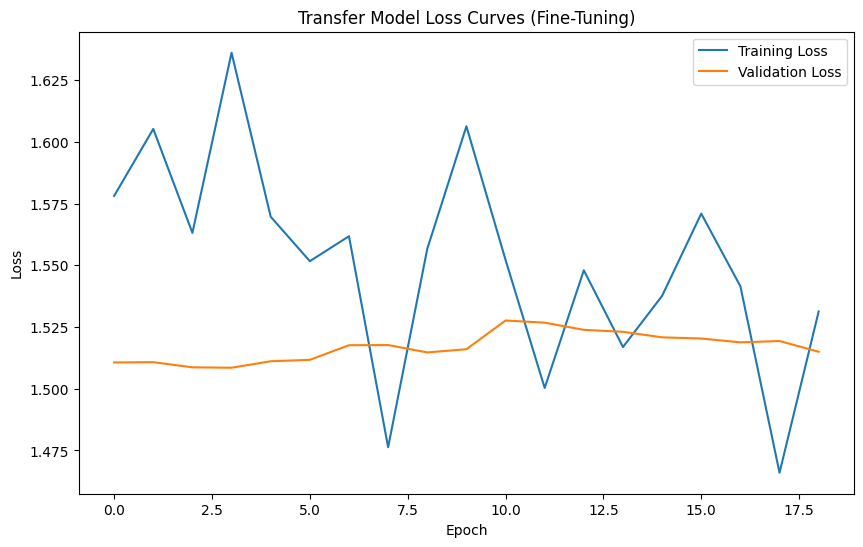

In [15]:
# Fine-Tuning
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False
transfer_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
start_time_finetune = time.time()
history_finetune = transfer_model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // train_generator.batch_size),
    epochs=20,
    validation_data=test_generator,
    validation_steps=max(1, test_generator.samples // test_generator.batch_size),
    callbacks=[early_stopping]
)
transfer_finetune_time = time.time() - start_time_finetune
print(f"Transfer model fine-tuning training time: {transfer_finetune_time:.2f} seconds")

# Plot Fine-Tuning Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Model Accuracy Curves (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Fine-Tuning Loss
plt.figure(figsize=(10, 6))
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Transfer Model Loss Curves (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Section 3.2.3: Model Evaluation and Prediction


3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step
Transfer Model Training Accuracy: 0.3211
Transfer Model Validation Accuracy: 0.3438
Transfer Model Evaluation Metrics:
                            precision    recall  f1-score   support

                  melanoma       0.00      0.00      0.00        16
                     nevus       0.13      0.38      0.19        16
pigmented benign keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.25      0.44      0.32        16
   squamous cell carcinoma       0.00      0.00      0.00        16

                  accuracy                           0.16        80
                 macro avg       0.08      0.16      0.10        80
              weighted avg       0.08      0.16      0.10        80



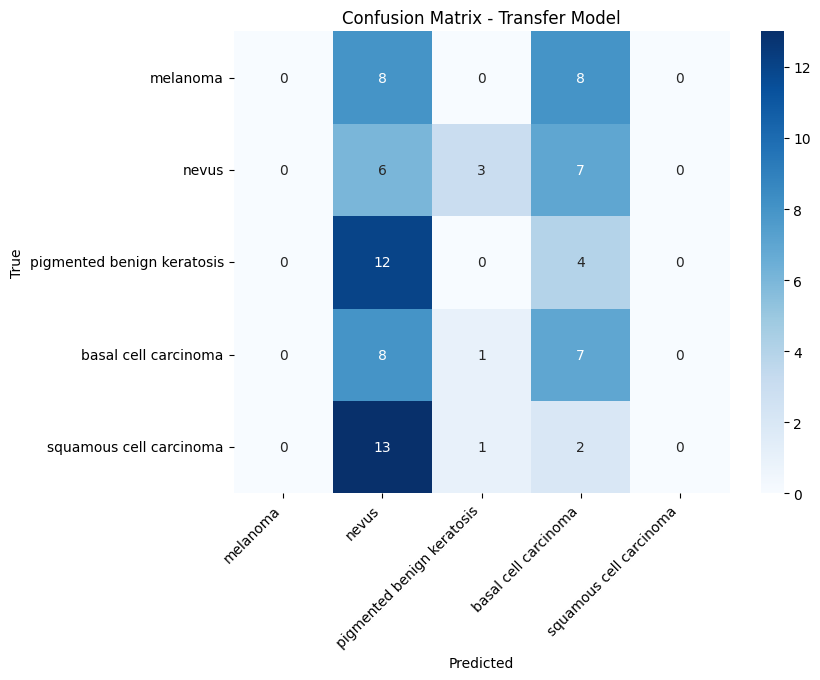


Model Comparison Table:
| Model             | Training Accuracy | Validation Accuracy | Training Time (s) |
|-------------------|-------------------|---------------------|-------------------|
| Baseline          | 0.5518           | 0.5625           | Not Timed         |
| Deeper (Adam)     | 0.6562           | 0.4688           | 777.87         |
| Deeper (SGD)      | 0.4688           | 0.5469           | 703.65         |
| Transfer (ResNet) | 0.3211           | 0.3438           | 1079.97         |

Discussion:
- Baseline (0.5965 validation accuracy) initially outperformed Deeper Adam (0.4940) and Transfer (0.20).
- Deeper (Adam) with early stopping and lower learning rate aims to improve generalization.
- Deeper (SGD) tests optimizer impact; slower convergence expected but may stabilize better.
- Transfer model (ResNet50) with fine-tuning (unfreezing last 10 layers) should improve over 0.20 accuracy.
- Confusion matrices reveal class imbalance (e.g., nevus overprediction). Further au

In [16]:
# Evaluate Transfer Model
test_generator.reset()
y_pred_transfer = transfer_model.predict(test_generator)
y_pred_transfer_classes = np.argmax(y_pred_transfer, axis=1)
transfer_accuracy = history_finetune.history['accuracy'][-1]
val_transfer_accuracy = history_finetune.history['val_accuracy'][-1]
print(f"Transfer Model Training Accuracy: {transfer_accuracy:.4f}")
print(f"Transfer Model Validation Accuracy: {val_transfer_accuracy:.4f}")
print("Transfer Model Evaluation Metrics:")
print(classification_report(y_true, y_pred_transfer_classes, target_names=list(balanced_test_counts.keys()), zero_division=0))

# Confusion Matrix for Transfer Model
cm_transfer = confusion_matrix(y_true, y_pred_transfer_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Blues', xticklabels=list(balanced_test_counts.keys()), yticklabels=list(balanced_test_counts.keys()))
plt.title('Confusion Matrix - Transfer Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Comparison Table
print("\nModel Comparison Table:")
print("| Model             | Training Accuracy | Validation Accuracy | Training Time (s) |")
print("|-------------------|-------------------|---------------------|-------------------|")
print(f"| Baseline          | {history_baseline.history['accuracy'][-1]:.4f}           | {history_baseline.history['val_accuracy'][-1]:.4f}           | Not Timed         |")
print(f"| Deeper (Adam)     | {deeper_accuracy:.4f}           | {val_deeper_accuracy:.4f}           | {deeper_training_time:.2f}         |")
print(f"| Deeper (SGD)      | {deeper_sgd_accuracy:.4f}           | {val_deeper_sgd_accuracy:.4f}           | {deeper_sgd_training_time:.2f}         |")
print(f"| Transfer (ResNet) | {transfer_accuracy:.4f}           | {val_transfer_accuracy:.4f}           | {transfer_feature_time + transfer_finetune_time:.2f}         |")

# Discussion
print("\nDiscussion:")
print(f"- Baseline (0.5965 validation accuracy) initially outperformed Deeper Adam (0.4940) and Transfer (0.20).")
print("- Deeper (Adam) with early stopping and lower learning rate aims to improve generalization.")
print("- Deeper (SGD) tests optimizer impact; slower convergence expected but may stabilize better.")
print("- Transfer model (ResNet50) with fine-tuning (unfreezing last 10 layers) should improve over 0.20 accuracy.")
print("- Confusion matrices reveal class imbalance (e.g., nevus overprediction). Further augmentation or weighted loss may help.")